In [1]:
from PIL import Image
from pathlib import Path
import pytesseract
import pandas as pd

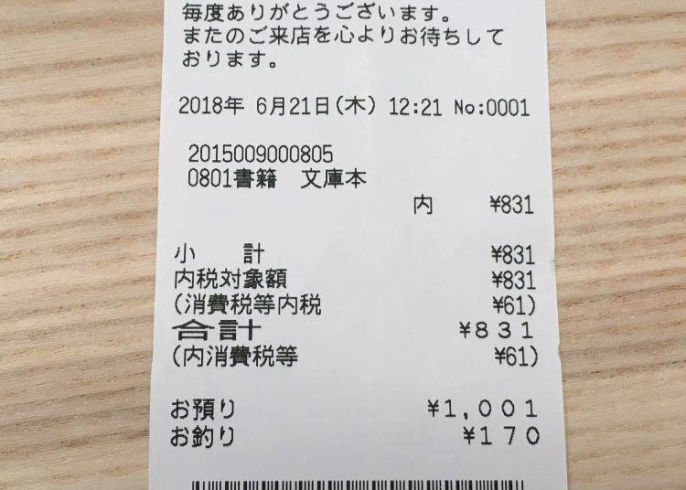

In [2]:
path_image = Path.cwd() / "images/000-receipt.jpg"
image = Image.open(path_image)
image

In [24]:
!convert {path_image} -rotate 90 images/90.jpg
!convert {path_image} -rotate 180 images/180.jpg
!convert {path_image} -rotate 270 images/270.jpg
!cp {path_image} images/0.jpg

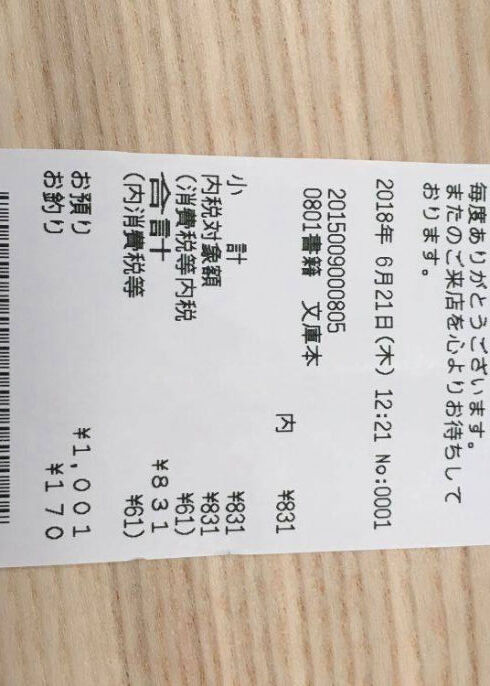

In [25]:
images = dict()
for angle in ["0", "90", "180", "270"]:
    images[angle] = Image.open(Path(f"images/{angle}.jpg"))
images["90"]

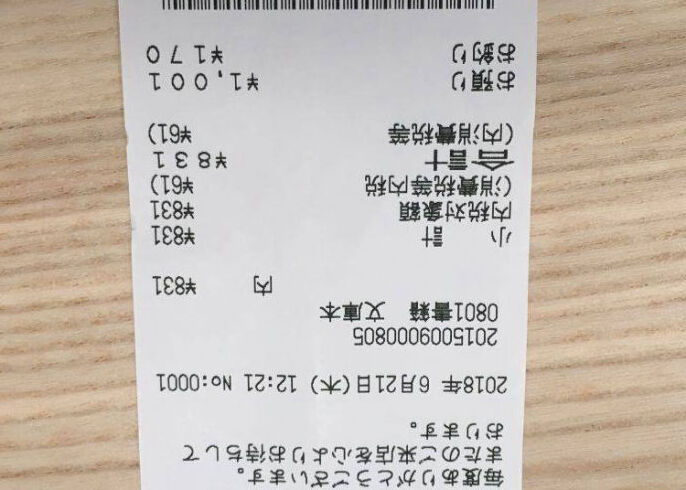

In [26]:
images["180"]

In [30]:
dfs = dict()
for angle in ["0", "90", "180", "270"]:
    dfs[angle] = pytesseract.image_to_data(images[angle], lang="jpn", output_type="data.frame")
    dfs[angle] = dfs[angle].dropna()
    dfs[angle] = dfs[angle].assign(
        bottom = lambda x: x.top + x.height,
        right = lambda x: x.left + x.width,
    )

In [31]:
dfs["90"]

level  page_num  block_num  par_num  line_num  word_num  left  top  \
4        5         1          1        1         1         1   468  183   
5        5         1          1        1         1         2   460  224   
6        5         1          1        1         1         3   470  251   
7        5         1          1        1         1         4   470  270   
8        5         1          1        1         1         5   470  293   
..     ...       ...        ...      ...       ...       ...   ...  ...   
112      5         1          3        2         7         3    59  212   
116      5         1          4        1         1         1     0  591   
120      5         1          5        1         1         1    42  170   
121      5         1          5        1         1         2    31  199   
122      5         1          5        1         1         3    43  220   

     width  height  conf text  bottom  right  
4       19      56    96    毎     239    487  
5       30      30    96    度     254    490  
6       16      12    96    あ     263    486  
7       17      17    96    り     287    487  
8       16       9    96    が     302    486  
..     ...     ...   ...  ...     ...    ...  
112     36      18    96    り     230     95  
116      0      95    95          686      0  
120     23      41    96    お     211     65  
121     38      24    93    釣     223     69  
122     21      13    97    り     233     64  

[96 rows x 14 columns]

In [32]:
dfs["180"]

level  page_num  block_num  par_num  line_num  word_num  left  top  \
4        5         1          1        1         1         1   146   45   
5        5         1          1        1         1         2   171   45   
6        5         1          1        1         1         3   194   45   
7        5         1          1        1         1         4   211   45   
8        5         1          1        1         1         5   452   42   
..     ...       ...        ...      ...       ...       ...   ...  ...   
100      5         1          3        1         2         8   411  470   
101      5         1          3        1         2         9   423  470   
102      5         1          3        1         2        10   442  469   
103      5         1          3        1         2        11   462  468   
104      5         1          3        1         2        12   489  464   

     width  height  conf text  bottom  right  
4       14      19    89    0      64    160  
5       11      19    63    て      64    182  
6       12      19    86    t      64    206  
7       12      19    39    ま      64    223  
8       64      23    54    U      65    516  
..     ...     ...   ...  ...     ...    ...  
100      5      16    61    返     486    416  
101     12      16    51    (     486    435  
102     16      17    49    ⑲     486    458  
103     36      19    49    蜀     487    498  
104     18      26     0    啓     490    507  

[84 rows x 14 columns]

In [33]:
from PIL import ImageDraw
from itertools import product
from copy import deepcopy, copy

def show_bbox(image, df):
    img = deepcopy(image)
    draw = ImageDraw.Draw(img)
    for row in df.itertuples():
        bbox = [row.left, row.top, row.right, row.bottom]
        draw.rectangle(
            bbox,
            outline="violet",
            width=2,
        )
    
        # naive
        #draw.point([(row.left, row.top)], fill="green")
    
        # more sophisticated
        n_px = 5
        draw.point(
            [(row.left+i, row.top+j) for i, j in product(range(n_px), range(n_px))],
            fill="green",
        )
    return img

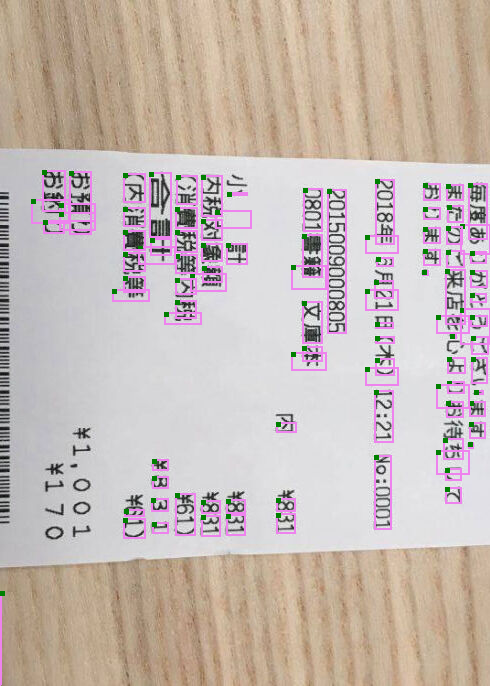

In [34]:
show_bbox(images["90"], dfs["90"])

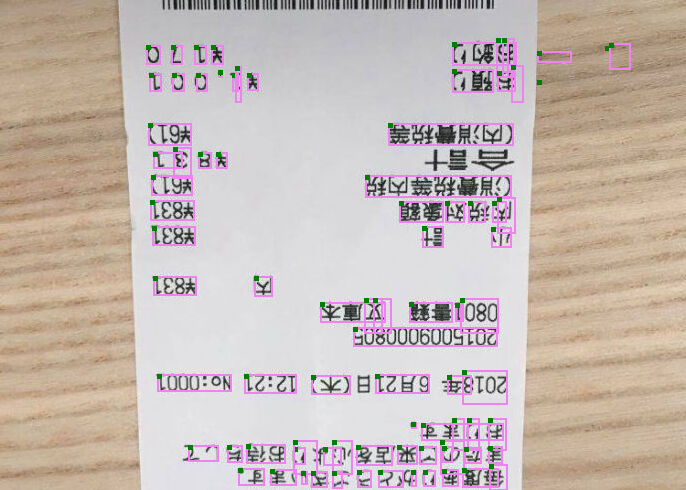

In [35]:
show_bbox(images["180"], dfs["180"])

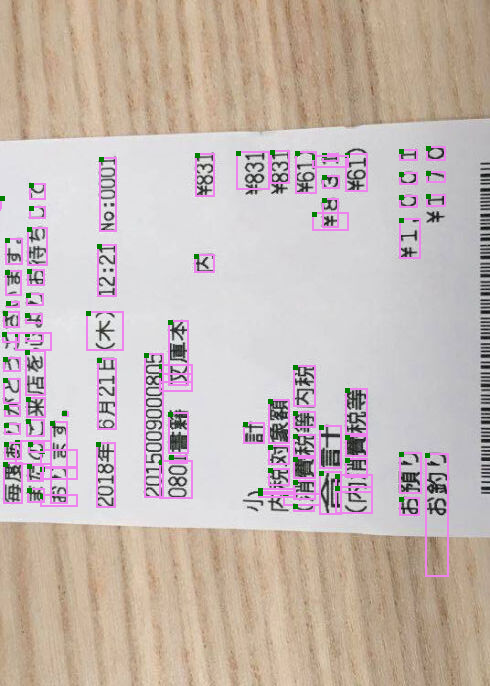

In [36]:
show_bbox(images["270"], dfs["270"])

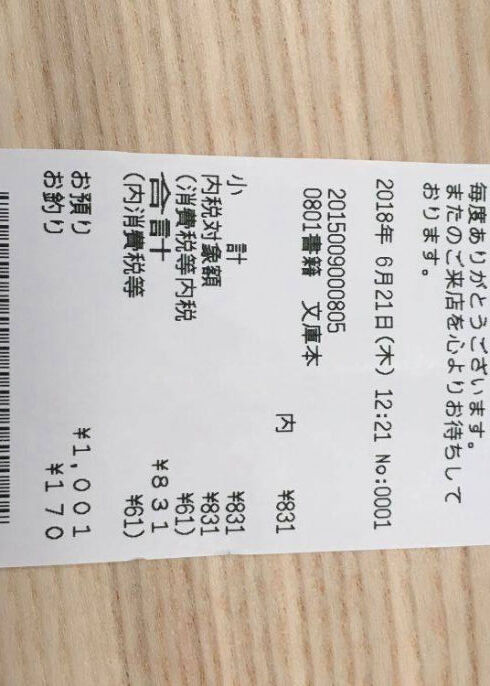

In [37]:
images["90"]

## Bad News
It seems that no matter how the image is rotated, the top left corner returned by `pytesseract` will always be w.r.t. the image, i.e. not w.r.t. the character. (Unlike LINE's <https://clova.ai/ocr>, which can help us deduce orientation.)

In [38]:
dfs["90"][["text", "left", "top", "right", "bottom", "conf"]]

text  left  top  right  bottom  conf
4      毎   468  183    487     239    96
5      度   460  224    490     254    96
6      あ   470  251    486     263    96
7      り   470  270    487     287    96
8      が   470  293    486     302    96
..   ...   ...  ...    ...     ...   ...
112    り    59  212     95     230    96
116          0  591      0     686    95
120    お    42  170     65     211    96
121    釣    31  199     69     223    93
122    り    43  220     64     233    97

[96 rows x 6 columns]

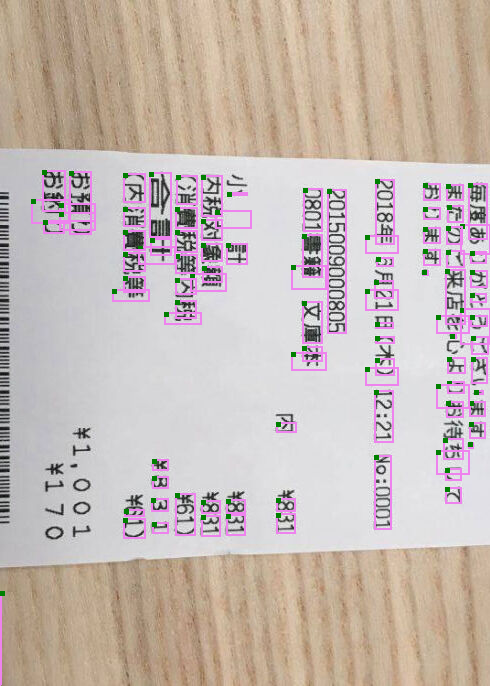

In [39]:
show_bbox(images["90"], dfs["90"])

For `180`-degree rotated images, it seems that `pytesseract` really intended to read the characters as-is, i.e. despite the characters being rotated upsidedown, it still tries its best to recognize them as "sth".

In [40]:
dfs["180"][["text", "left", "top", "right", "bottom", "conf"]]

text  left  top  right  bottom  conf
4      0   146   45    160      64    89
5      て   171   45    182      64    63
6      t   194   45    206      64    86
7      ま   211   45    223      64    39
8      U   452   42    516      65    54
..   ...   ...  ...    ...     ...   ...
100    返   411  470    416     486    61
101    (   423  470    435     486    51
102    ⑲   442  469    458     486    49
103    蜀   462  468    498     487    49
104    啓   489  464    507     490     0

[84 rows x 6 columns]

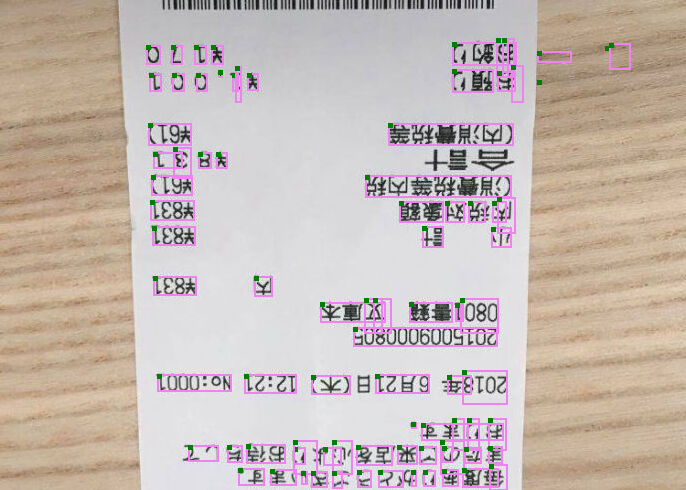

In [41]:
show_bbox(images["180"], dfs["180"])

In [42]:
dfs["270"][["text", "left", "top", "right", "bottom", "conf"]]

text  left  top  right  bottom  conf
4              0  196      0     210    95
8        0   426  146    445     160    95
9        て   426  171    445     182    60
10       t   426  194    445     206     0
11   D寵樽畷`   425  453    448     576    62
..     ...   ...  ...    ...     ...   ...
104      マ     3  378     20     403    90
105      返     4  405     20     416    52
106      G     4  423     20     434    62
107      ①     4  442     21     459    85
108      朗     3  462     22     503     0

[85 rows x 6 columns]

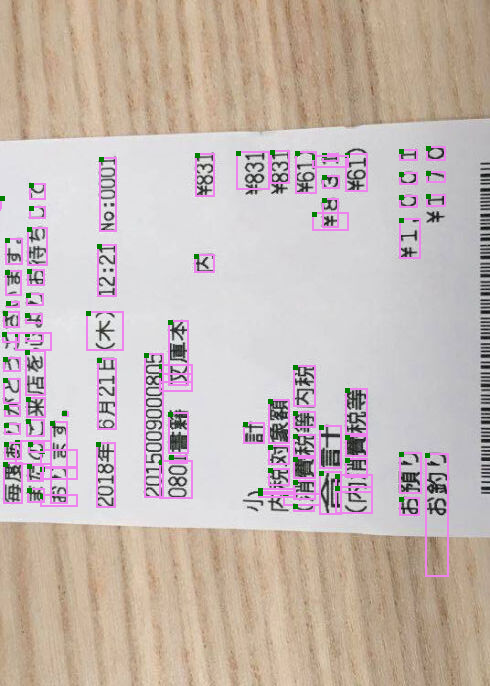

In [43]:
show_bbox(images["270"], dfs["270"])

## So..., No Ways to Deduce Orientation?
Maybe one last chance is to compare confidence score. `180` and `270` images are all of low confidence; by contrast, `90` image has quite high confidence.

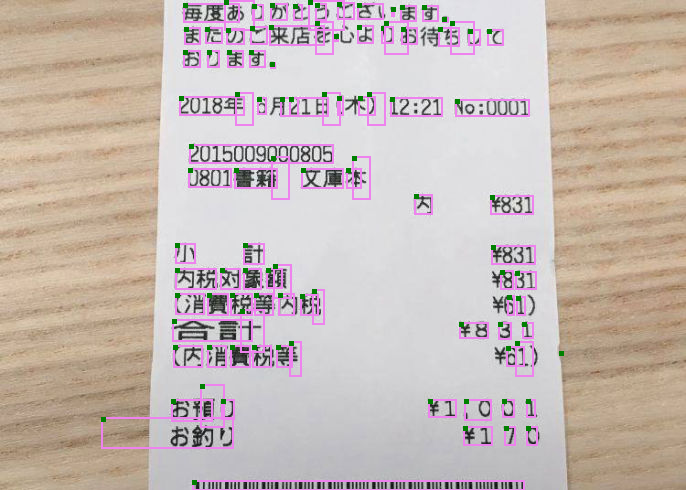

In [48]:
show_bbox(images["0"], dfs["0"])

In [46]:
dfs["0"][["text", "conf"]]

text  conf
4        毎    96
5        度    96
6        あ    96
7        り    96
8        が    96
..     ...   ...
117  〕】ぉ艶リ    54
118     \①    68
119      ⑦    95
120      0    90
124      a     0

[98 rows x 2 columns]

In [47]:
dfs["90"][["text", "conf"]]

text  conf
4      毎    96
5      度    96
6      あ    96
7      り    96
8      が    96
..   ...   ...
112    り    96
116         95
120    お    96
121    釣    93
122    り    97

[96 rows x 2 columns]

In [49]:
dfs["0"]["conf"].sum()

8201

In [50]:
dfs["90"]["conf"].sum()

8445

In [51]:
dfs["180"]["conf"].sum()

4054

In [52]:
dfs["270"]["conf"].sum()

4451

In [53]:
for df in dfs.values():
    print(df["conf"].sum() / df.shape[0])

83.68367346938776
87.96875
48.26190476190476
52.36470588235294
